<a href="https://colab.research.google.com/github/raihanewubd/CNNwithEvolutionary-algorithms/blob/main/CNNwithEvolutionaryV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import psutil

In [2]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

# Transformations for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

In [3]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:02<00:00, 85.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [138]:
train_dataset[0][0].shape

torch.Size([3, 32, 32])

In [139]:
train_dataset[0][1]

6

In [140]:
print(f"{len(train_dataset)} {type(train_dataset)}")


50000 <class 'torchvision.datasets.cifar.CIFAR10'>


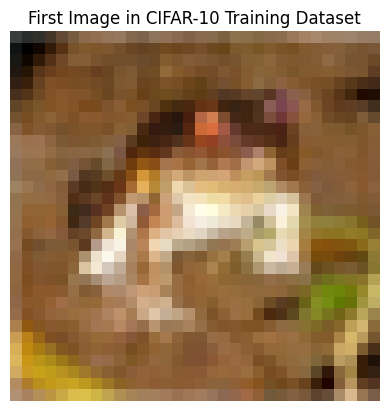

In [141]:
# Get the image tensor
image_tensor = train_dataset[0][0]

# Convert the image tensor to a NumPy array
image_np = image_tensor.numpy()

# Transpose the dimensions to (height, width, channels) for Matplotlib
image_np = np.transpose(image_np, (1, 2, 0))

# Un-normalize the image if you normalized it during preprocessing
# Assuming you normalized to [-1, 1] using transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
image_np = (image_np * 0.5) + 0.5  # Un-normalize to [0, 1]

# Clip values to be in the range [0, 1]
image_np = np.clip(image_np, 0, 1)

# Display the image using Matplotlib
plt.imshow(image_np)
plt.title("First Image in CIFAR-10 Training Dataset")
plt.axis('off')  # Turn off axis ticks and labels
plt.show()

In [4]:
class SimplifiedCNN(nn.Module):
    def __init__(self):
        super(SimplifiedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        dummy_input = torch.randn(1, 3, 32, 32)
        out = self.pool(F.relu(self.conv2(F.relu(self.conv1(dummy_input)))))
        self.feature_size = out.numel()

        self.fc1 = nn.Linear(self.feature_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [143]:
# Training Loop
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

In [144]:
# Testing Loop
def test(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

In [145]:
# Define Model, Loss Function, and Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimplifiedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [146]:
# Train and Test the Model
train(model, train_loader, criterion, optimizer, num_epochs)
test(model, test_loader, criterion)

Epoch [1/10], Loss: 1.6646
Epoch [2/10], Loss: 1.4145
Epoch [3/10], Loss: 1.2895
Epoch [4/10], Loss: 1.2213
Epoch [5/10], Loss: 1.1700
Epoch [6/10], Loss: 1.1297
Epoch [7/10], Loss: 1.0939
Epoch [8/10], Loss: 1.0596
Epoch [9/10], Loss: 1.0374
Epoch [10/10], Loss: 1.0051
Test Loss: 0.9640, Test Accuracy: 0.6621


In [5]:
def get_flat_params(model):
    # Get all model parameters as a flattened numpy array
    return np.concatenate([param.data.cpu().numpy().flatten() for param in model.parameters()])

#def set_flat_params(model, flat_params):
    # Set model parameters from a flattened numpy array
#    idx = 0
    #for param in model.parameters():
     #   param_size = param.numel()
      #  param.data = torch.tensor(flat_params[idx:idx + param_size].reshape(param.size())).to(param.device)
       # idx += param_size


In [6]:
def set_flat_params(model, flat_params):
    idx = 0
    flat_params = torch.tensor(flat_params, dtype=torch.float32, device=next(model.parameters()).device)
    for param in model.parameters():
        param_size = param.numel()
        param.data = flat_params[idx:idx + param_size].view(param.size())
        idx += param_size

In [7]:
def evaluate_model(model, dataloader, criterion):
    # Calculate loss for a single epoch
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(dataloader)


In [8]:
def print_memory_usage():
    """Print the memory usage of the current process."""
    process = psutil.Process()
    memory_info = process.memory_info()
    print(f"Memory Usage: {memory_info.rss / (1024 ** 2):.2f} MB")  # Resident Set Size (RSS) in MB

In [15]:
def differential_evolution(fitness_function, bounds, population_size=20, generations=100, mutation=0.8, recombination=0.7):
    dim = len(bounds)
    population = np.random.rand(population_size, dim)
    for i, (low, high) in enumerate(bounds):
        population[:, i] = low + population[:, i] * (high - low)

    best_params = population[0]  # Initialize with the first individual
    best_score = float("inf")

    for gen in range(generations):
        print(f"Generation {gen + 1}")
        print_memory_usage()

        generation_loss = []
        generation_accuracy = []
        print(f"Generation begin population size")
        for i in range(population_size):
            if (i + 1) % 50 == 0:
              print('.', end='', flush=True)
            idxs = [idx for idx in range(population_size) if idx != i]
            a, b, c = population[np.random.choice(idxs, 3, replace=False)]
            mutant = np.clip(a + mutation * (b - c), 0, 1)
            trial = np.copy(population[i])
            for j in range(dim):
                if np.random.rand() < recombination:
                    trial[j] = mutant[j]

            # Evaluate fitness and accuracy
            fitness, accuracy = fitness_function(trial)
            generation_loss.append(fitness)
            generation_accuracy.append(accuracy)

            if fitness < fitness_function(population[i])[0]:  # Compare fitness only
                population[i] = trial
                if fitness < best_score:
                    best_score = fitness
                    best_params = trial

        # Log average loss and accuracy for the generation
        avg_loss = sum(generation_loss) / len(generation_loss)
        avg_accuracy = sum(generation_accuracy) / len(generation_accuracy)
        print(f"Generation {gen + 1} - Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.4f} -Best Loss So Far: {best_score}- Memory Uasage{print_memory_usage()}")

    return best_params, best_score




In [10]:
def objective_functionV1(params, model, input_tensor, target_tensor, loss_function):
    # Set model parameters
    set_flat_params(model, params)

    # Forward pass
    output = model(input_tensor)

    # Compute loss
    loss = loss_function(output, target_tensor.long()).item()

    # Compute accuracy
    _, predicted = torch.max(output, 1)
    accuracy = (predicted == target_tensor).sum().item() / target_tensor.size(0)

    return loss, accuracy

In [11]:
def objective_function(params, model, dataloader, loss_function):
    set_flat_params(model, params)
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels).item()
            total_loss += loss * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usage device {device}")
model = SimplifiedCNN().to(device)
criterion = nn.CrossEntropyLoss()

# Objective function for DE
#def objective_function(flat_params):
#    set_flat_params(model, flat_params)
#    return evaluate_model(model, train_loader, criterion)

# Prepare input and target tensors
input_tensor, target_tensor = next(iter(train_loader))
input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

# Bounds for parameters
flat_params = get_flat_params(model)
bounds = np.array([(-1, 1) for _ in flat_params])  # Adjust bounds as needed
#best_params = differential_evolution(objective_function, bounds, population_size=5, generations=50)
best_params = differential_evolution(
    #lambda params: objective_function(params, model, input_tensor, target_tensor, criterion),

    lambda params: objective_function(params, model, train_loader, criterion),
    bounds,
    population_size=10,
    generations=100
)

Usage device cpu
Generation 1
Memory Usage: 1609.68 MB
Generation begin population size


In [154]:
def evaluate_model_on_test(model, dataloader, criterion):
    """
    Evaluate the model on the test dataset and calculate accuracy and loss.
    """
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


In [155]:
if best_params is None:
    raise ValueError("Optimization failed: best_params is None.")

# Set the best parameters to the model
set_flat_params(model, best_params[0])

# Evaluate on the test dataset
test_loss, test_accuracy = evaluate_model_on_test(model, test_loader, criterion)

# Print the test results
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")


Final Test Loss: 1885.5419
Final Test Accuracy: 0.0907


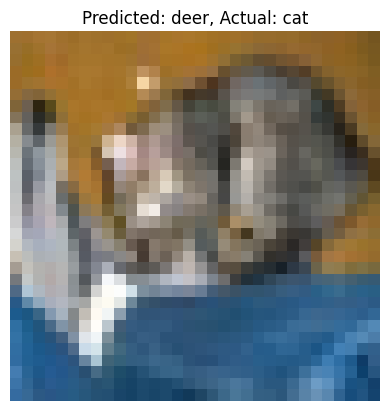

Final Test Loss: 1885.5419
Final Test Accuracy: 0.0907


In [156]:
def display_test_result(model, test_loader, device, class_names):
    """
    Displays a single test image with its predicted and actual label.
    """
    model.eval()

    # Get a single batch from the test loader
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Move data to the appropriate device
    images, labels = images.to(device), labels.to(device)

    # Get predictions
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Choose an image to display (e.g., the first image in the batch)
    image_index = 0
    image = images[image_index].cpu()  # Move image to CPU for plotting
    label = labels[image_index].item()
    prediction = predicted[image_index].item()

    # Un-normalize the image for display
    image = (image * 0.5) + 0.5  # Un-normalize to [0, 1]
    image = np.transpose(image.numpy(), (1, 2, 0))  # Transpose for Matplotlib

    # Display the image
    plt.imshow(image)
    plt.title(f"Predicted: {class_names[prediction]}, Actual: {class_names[label]}")
    plt.axis('off')
    plt.show()

# ... (Previous code remains the same) ...

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Set the best parameters to the model
set_flat_params(model, best_params[0])

# Display one test result
display_test_result(model, test_loader, device, class_names)

# Evaluate on the test dataset and print overall results
test_loss, test_accuracy = evaluate_model_on_test(model, test_loader, criterion)
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")